Ensemble Classifiers:
Random Forests
AdaBoost

Created: 4/13/2020
Last Modified: 4/13/2020
Author: Sarah Mounho

In [1]:
#Library Imports
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sarah\Anaconda3\envs\CS329E_Project\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#import clean data
from utils import intake_data
data_X, data_Y = intake_data()

TEST


In [8]:
#Confusion Matrix Function
#Create a confusion matrix
#Inputs:
#Y_Actual = Actual (true) labels
#Y_Predicted = Predicted labels from a classifier
#classifier = Name of classifier as a string for plt title
def create_cm (Y_Actual, Y_Predicted, classifier=None):
    try: 
        import seaborn as sn
    except:
        print('create_cm(Y_Actual, Y_Predicted, classifier) has a dependency on the library seaborn.')
        print('This library was not found, please install and try again.')
        return()
    if type(classifier) != str:
        print('Please input the name of the classifier for plt title as a str')
        return()

            
    data = {'Actual': Y_Actual, 'Predicted':Y_Predicted}
    df = pd.DataFrame(data, columns=['Actual', 'Predicted'])
    df['Predicted'].replace(0, 'Alive', inplace=True)
    df['Predicted'].replace(1, 'Dead', inplace=True)
    df['Actual'].replace(0, 'Alive', inplace=True)
    df['Actual'].replace(1, 'Dead', inplace=True)
    cm = pd.crosstab(df['Actual'], df['Predicted'],
                     rownames=['Actual'], colnames=['Predicted'])                                    
    #Print a formatted confusion matrix using a heatmap
    sn.heatmap(cm, annot=True)
    plt_title = 'Confusion Matrix for ' + classifier
    plt.title(plt_title)
    plt.show()

###### Random Forest Classifier 
Random Forests are an extension of bagged decision trees. They randomly select a subset of the input features for candidate splits to test. The feature with the best gain is selected from the subset. This process is repeated many times. The class label is then decided based on the most frequent classification from the trees. The samples are drawn with replacement.   

***Hyperparameters:***  
  
*max_depth*- The maximumm depth of the tree. The range of values tested for max_depth are: [1, 10, 20, 30, 40, 50]  
  
*min_samples_leaf*- The minimum number of samples required to be a leaf node. The tree will not be split if less than min_samples_leaf is left in either the left or right branch. The range of values tested for min_samples_leafe are: [1, 2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].  
  
*max_features*- The number of features to consider when looking for the best split. Consider sqrt(n_features) and log2(n_features).  
  


Best values for RandomForestClassifier are:
max_depth: 10 
min_samples_leaf: 1 
max_features: log2
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       127
           1       0.70      0.75      0.72       127

    accuracy                           0.71       254
   macro avg       0.71      0.71      0.71       254
weighted avg       0.71      0.71      0.71       254



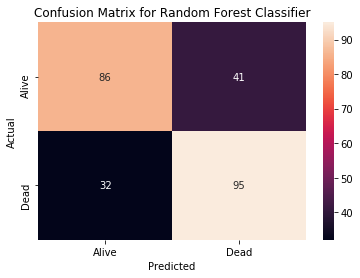

In [9]:
from sklearn.ensemble import RandomForestClassifier as RFC

#Create a random forest classifier
rfc = RFC()
#params 
max_depth_lst = list(range(1, 51, 9))
min_leaf_lst = list(range(1, 15))
param_grid = {'max_depth': max_depth_lst,
              'min_samples_leaf': min_leaf_lst,
              'max_features': ['sqrt', 'log2']    
}
#grid search for best max depth, min samples per leaf and max features
clf = GridSearchCV(rfc, param_grid, cv=5)
#fit model to output best hyperparameters
clf.fit(data_X, data_Y)
print('Best values for RandomForestClassifier are:\n'+
      'max_depth:', clf.best_params_['max_depth'], '\n'+
      'min_samples_leaf:', clf.best_params_['min_samples_leaf'], '\n'+
      'max_features:', clf.best_params_['max_features'])
#cross validation
Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)

#Report
print(classification_report(data_Y, Y_pred, labels=[0, 1]))

#Create a confusion matrix
create_cm (data_Y, Y_pred, classifier='Random Forest Classifier')


###### Boosting
  
AdaBoostClassifier is an ensemble classifier that iteratively changes the distribution of the training data. The base classifiers focus on hard to classify examples by assigning a weight to each example and updating that weight at the end of each boosting rund. The weight is then used as a sampling dsitribution to draw a set of bootstrap samples. The base estimator is a DecisionTreeClassifier(max_depth=1).  
  
***Hyperparameters:***  
  
*number of estimators*- The maximum number of estimators before the boosting is terminated.

Best value for AdaBoostClassifier is:
n_estimators: 5
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       127
           1       0.66      0.69      0.67       127

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.67       254
weighted avg       0.67      0.67      0.67       254



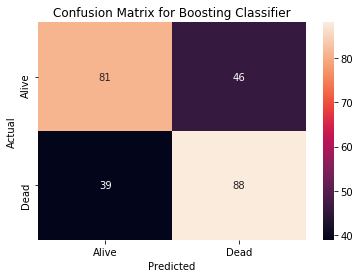

In [10]:
from sklearn.ensemble import AdaBoostClassifier as ABC
#create an AdaBoostClassifier
abc = ABC()
#params
est_lst = list(range(5, 200, 5))
param_grid = {'n_estimators': est_lst}
#grid search for best n_estimators
clf = GridSearchCV(abc, param_grid, cv=5)
#cross validation
Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
#fit model to output best hyperparameters
clf.fit(data_X, data_Y)
print('Best value for AdaBoostClassifier is:\n'+
      'n_estimators:', clf.best_params_['n_estimators'])
#Report
print(classification_report(data_Y, Y_pred, labels=[0, 1]))

#Create a confusion matrix
create_cm (data_Y, Y_pred, classifier='Boosting Classifier')
